In [1]:
!pip install prophet matplotlib pandas numpy

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ----------- ---------------------------- 3.7/13.3 MB 19.9 MB/s eta 0:00:01
   ------------ --------------------------- 4.2/13.3 MB 14.2 MB/s eta 0:00:01
   -------------- ------------------------- 5.0/13.3 MB 7.5 MB/s eta 0:00:02
   ------------------ --------------------- 6.3/13.3 MB 7.6 MB/s eta 0:00:01
   -------------------- ------------------- 6.8/13.3 MB 6.7 MB/s eta 0:00:01
   ---------------------- ----------------- 7.6/13.3 MB 5.7 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.3 MB 5.7 MB/s eta 0:00:01
   ----------------------------- ---------- 9.7/13.3 MB 5.6 MB/s eta 0:00:01
   ------------------------------- -------- 10.5/13.3 MB 5.4 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.3 MB 5.1 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 4.9 MB/s eta 0:00:01
   -------------------------------------- - 12.8/13.3 MB 4.9 MB/s eta 0:00:01



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [4]:
try:
    df_train = pd.read_csv("C:/Users/M F Mohamed Ajmal/OneDrive/Desktop/project/storesaleprediction/train.csv", parse_dates=['date'])
    df_holidays = pd.read_csv("C:/Users/M F Mohamed Ajmal/OneDrive/Desktop/project/storesaleprediction/holidays_events.csv", parse_dates=['date'])
except FileNotFoundError:
    print("ERROR: Please ensure 'train.csv' and 'holidays_events.csv' are in the same directory.")
    raise

In [5]:
STORE_ID = 1
PRODUCT_FAMILY = 'GROCERY I'

df_prototype = df_train[
    (df_train['store_nbr'] == STORE_ID) & 
    (df_train['family'] == PRODUCT_FAMILY)
]

In [6]:
df_prophet = df_prototype.rename(columns={'date': 'ds', 'sales': 'y'})
df_prophet = df_prophet[['ds', 'y']]

# Handle missing or zero sales (e.g., store was closed) by dropping or setting to NaN.
# For simplicity, we drop any rows where sales are 0 or less.
df_prophet = df_prophet[df_prophet['y'] > 0]

In [7]:
df_holidays = df_holidays[df_holidays['locale'] == 'National']
df_holidays = df_holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})

# Drop Transfer/Work Day events as they can confuse the model for a prototype
df_holidays = df_holidays[~df_holidays['holiday'].str.contains('Transfer|Work Day')]

# Ensure the 'holiday' column is unique for a given date
df_holidays = df_holidays.drop_duplicates(subset=['ds']).reset_index(drop=True)

print(f"--- Prototype Data Loaded and Filtered ---")
print(f"Target: Store {STORE_ID}, Family: {PRODUCT_FAMILY}")
print(f"Historical Sales Data Points: {len(df_prophet)}")
print(f"Holidays to be used: {len(df_holidays)}")
print("\nSample of Prepared Sales Data:")
print(df_prophet.tail(3))
print("\nSample of Prepared Holiday Data:")
print(df_holidays.head(3))

--- Prototype Data Loaded and Filtered ---
Target: Store 1, Family: GROCERY I
Historical Sales Data Points: 1678
Holidays to be used: 168

Sample of Prepared Sales Data:
                ds       y
2995554 2017-08-13   952.0
2997336 2017-08-14  2407.0
2999118 2017-08-15  2508.0

Sample of Prepared Holiday Data:
          ds                              holiday
0 2012-08-10        Primer Grito de Independencia
1 2012-10-09           Independencia de Guayaquil
2 2012-10-12  Traslado Independencia de Guayaquil


In [8]:
m = Prophet(
    # Set the uncertainty interval (e.g., 90% confidence)
    interval_width=0.90,
    yearly_seasonality=True,
    weekly_seasonality=True,
    # Add the holidays dataframe to the model
    holidays=df_holidays 
)

# Fit the model to the historical sales data
m.fit(df_prophet)

19:25:05 - cmdstanpy - INFO - Chain [1] start processing
19:25:07 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
FORECAST_DAYS = 60 # ~2 months

# Create a future DataFrame for the next 60 days
future = m.make_future_dataframe(periods=FORECAST_DAYS, freq='D')


In [10]:
forecast = m.predict(future)

print(f"\n--- {FORECAST_DAYS}-Day Forecast Snapshot ---")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


--- 60-Day Forecast Snapshot ---
             ds         yhat   yhat_lower   yhat_upper
1733 2017-10-10  2960.796709  2445.697315  3488.589606
1734 2017-10-11  3297.920878  2781.822157  3853.061768
1735 2017-10-12  2753.691204  2199.583742  3304.901951
1736 2017-10-13  2996.841050  2461.469895  3527.250658
1737 2017-10-14  2815.481161  2280.610169  3326.665391


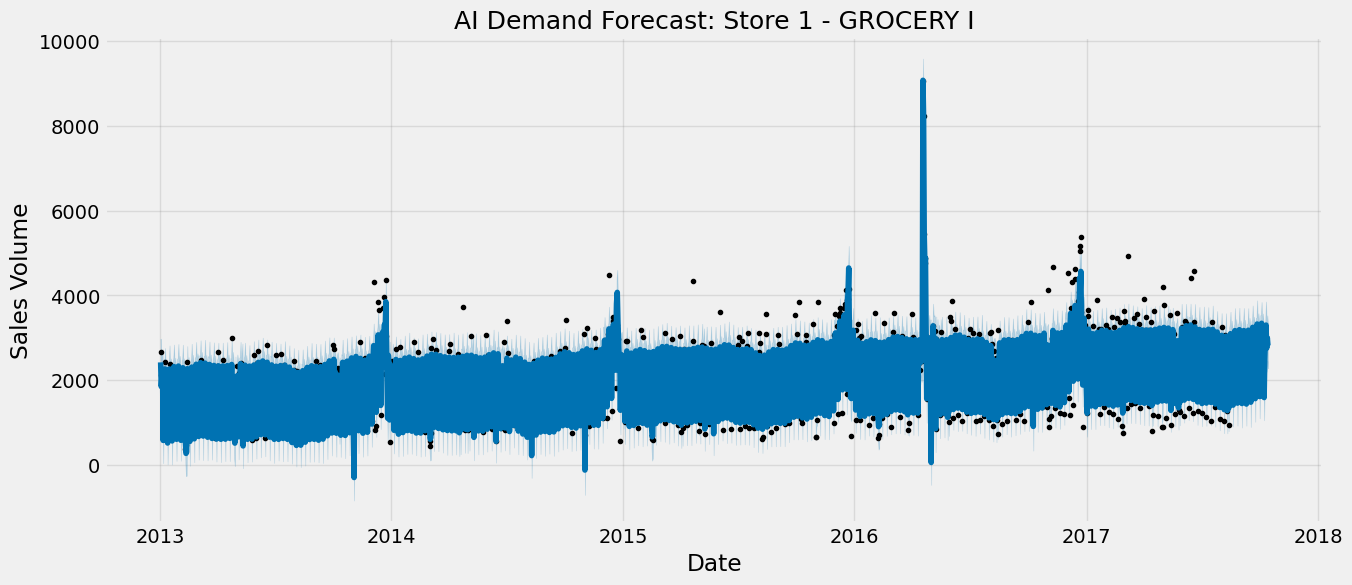

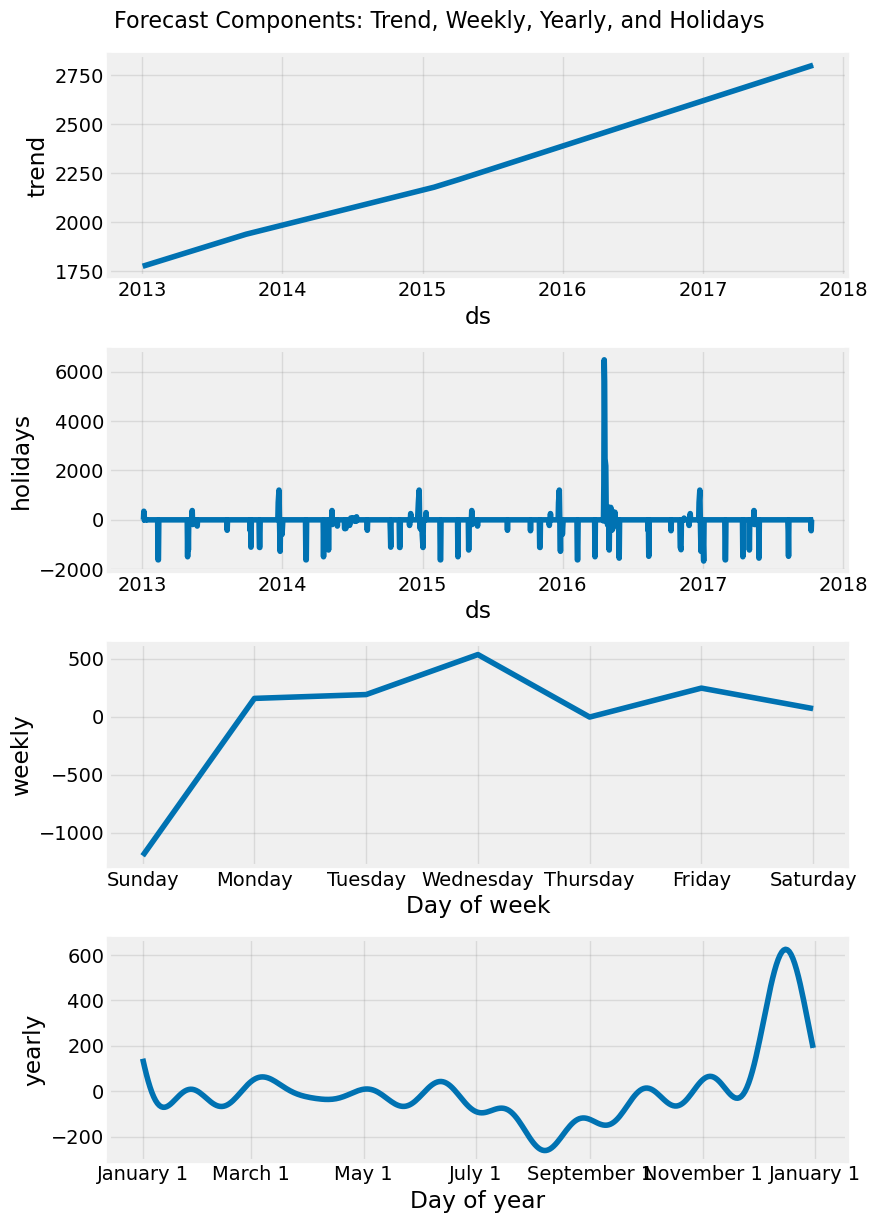

In [11]:
plt.style.use('fivethirtyeight') # A nice style for data visualization

# Plot the forecast
fig, ax = plt.subplots(figsize=(14, 6))
fig = m.plot(forecast, ax=ax)
ax.set_title(f"AI Demand Forecast: Store {STORE_ID} - {PRODUCT_FAMILY}", fontsize=18)
ax.set_xlabel("Date")
ax.set_ylabel("Sales Volume")
plt.show()

# Plot the Trend and Seasonality Components
fig_comp = m.plot_components(forecast)
plt.suptitle("Forecast Components: Trend, Weekly, Yearly, and Holidays", y=1.02, fontsize=16)
plt.show()

In [12]:
future_forecast = forecast.tail(FORECAST_DAYS)

# Calculate key metrics
total_predicted_sales = future_forecast['yhat'].sum()
recommended_stock_lower_bound = future_forecast['yhat_lower'].sum() 
inventory_buffer_multiplier = 1.15 # 15% safety stock buffer

final_inventory_recommendation = recommended_stock_lower_bound * inventory_buffer_multiplier

print("\n" + "="*80)
print(f"  *** AI RETAIL ANALYTICS: INVENTORY RECOMMENDATION REPORT ***")
print(f"  Focus: Store {STORE_ID} | Product Family: {PRODUCT_FAMILY}")
print(f"  Forecast Horizon: {FORECAST_DAYS} Days")
print("="*80)
print(f" 🎯 Total Predicted Sales: {total_predicted_sales:,.0f} units")
print(f" 📉 90% Confidence Lower Bound (Safety Target): {recommended_stock_lower_bound:,.0f} units")
print("\n🔥 **ACTIONABLE INVENTORY PLAN:**")
print(f"   Recommended Stock Level (with {inventory_buffer_multiplier*100-100:,.0f}% Safety Buffer):")
print(f"   You should plan to have a minimum of **{final_inventory_recommendation:,.0f}** units in stock to prevent stockouts.")
print("="*80)


  *** AI RETAIL ANALYTICS: INVENTORY RECOMMENDATION REPORT ***
  Focus: Store 1 | Product Family: GROCERY I
  Forecast Horizon: 60 Days
 🎯 Total Predicted Sales: 162,093 units
 📉 90% Confidence Lower Bound (Safety Target): 129,984 units

🔥 **ACTIONABLE INVENTORY PLAN:**
   Recommended Stock Level (with 15% Safety Buffer):
   You should plan to have a minimum of **149,481** units in stock to prevent stockouts.
